# Snakes and Sequences: Senegalese Serpent Venom Sequencing Hackathon


<figure>
<center>
<img src='https://ideogram.ai/assets/image/lossless/response/OSUbpH_nTg6_IHiRw-9YPg' />
</figure>

<font color='grey'>Image source: created using [ideogram.ai](https://ideogram.ai/g/CD9hdRnmQTCEIMGBfiDeiw/2)</font>


Snakes pose a significant danger in Senegal, where encounters with venomous species can lead to severe injury or even death. The diversity and potency of snake venoms in the region present a major public health challenge, with traditional methods of antivenom production often falling short due to the unique and complex nature of these venoms. This is where [tandem mass spectrometry](https://en.wikipedia.org/wiki/Tandem_mass_spectrometry) combined with [_de novo_ peptide sequencing](https://en.wikipedia.org/wiki/De_novo_peptide_sequencing) could potentially play a role.

_De novo_ peptide sequencing involves determining the amino acid sequence of peptides from a mass spectrum without prior knowledge of the protein sequence, potentially making it a tool in the fight against snake bites. Unlike traditional database search methods, which rely on existing sequence databases and often fail when encountering novel or highly variable venom components, _de novo_ sequencing provides an unbiased and comprehensive analysis of venom peptides. This approach could potentially allow for the identification of new and unique venom peptides, which is crucial for the development of effective and specific antivenoms.

By leveraging mass spectrometry with _de novo_ peptide sequencing, researchers could potentially create tailored antivenoms that are more effective against the diverse snake venom profiles found in Senegal. If successful, This may have the potential not only to improve the chances of survival for snakebite victims but also to enhance the overall public health response to snakebite emergencies. We believe that the ability to rapidly and accurately sequence venom peptides could represent a significant advancement in our efforts to combat the dangers posed by snakes in Senegal and beyond.

## The Task: recalibrating model predictions

How can we help? In this hackathon we will be improving existing _de novo_ peptide sequencing models. Specifically, we will be looking into recalibration and filtering! Rather than training a large _de novo_ sequencing model from scratch, we will focus on using various techniques to improve the area under the curve (AUC) for the precision-recall graph. Due to high noise, our models are often not super well calibrated.

InstaDeep has developed a transformer-based _de novo_ peptide sequencing model **InstaNovo** [[preprint](https://www.biorxiv.org/content/10.1101/2023.08.30.555055v3)][[code](https://github.com/instadeepai/InstaNovo)]. 
We will provide you with the inputs AND outputs of InstaNovo along with some additional metadata (eg. retention time). The InstaNovo outputs includes the top 5 beam predictions along with their model confidences.
Your task is to use these inputs and metadata to re-calibrate the confidence measurements and filter out any **false positives in order to maximise the AUC!**

# Introduction to Mass Spectrometry for _De Novo_ Peptide Sequencing
Mass spectrometry (MS) is an analytical technique used to measure the mass-to-charge ratio (m/z) of ions. It is widely used in proteomics, especially for _de novo_ sequencing, where the goal is to determine the amino acid sequence of a peptide directly from the mass spectrometric data without prior knowledge of the sequence.

## Process Overview:
- **Ionization:** The peptide sample is ionized, usually by electrospray ionization (ESI) or matrix-assisted laser desorption/ionization (MALDI), generating charged peptide ions.

- **Mass Analysis (MS1):** The ionized peptides are first separated based on their m/z ratios. The resulting spectrum (MS1) shows the m/z values of the precursor ions (the intact peptides).

- **Fragmentation:** Selected precursor ions are further fragmented into smaller ions. This fragmentation process is critical for _de novo_ sequencing as it generates the ion fragments needed to determine the peptide sequence.

- **Mass Analysis (MS2):** The fragments are analyzed to produce an MS2 spectrum, where the mz_array represents the m/z values of the fragment ions and the intensity_array reflects their abundance.

- **_De Novo_ Sequencing:** The MS2 data (mz_array and intensity_array) are used to infer the peptide sequence. By analyzing the differences between the m/z values, the sequence of the peptide can be reconstructed.


<figure>
<img src='https://raw.githubusercontent.com/BioGeek/hackathon_indaba_senegal_2024/main/imgs/de_novo.png'/>
</figure>

<font color='grey'>Image sources: [Vanquish™ Neo UHPLC](https://www.thermofisher.com/order/catalog/product/VN-S10-A-01) and [Orbitrap Exploris](https://www.thermofisher.com/order/catalog/product/BRE725539)</font>

## The data

In [35]:
!python --version

Python 3.12.3


In [36]:
# Install koinapy for Prosit API
#!pip install koinapy matplotlib numpy pandas

In [37]:
from importlib.metadata import version

# check the version of libraries
pkgs = ['koinapy', 'matplotlib', 'numpy', 'pandas', 'scikit-learn', "ydata-profiling"]

for pkg in pkgs:
    print(f'{pkg}: {version(pkg)}')

koinapy: 0.0.8
matplotlib: 3.9.2
numpy: 1.26.4
pandas: 2.2.2
scikit-learn: 1.5.1
ydata-profiling: 4.9.0


In [38]:
import bisect
import re
import os

import koinapy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


Download the `Train.csv` and `Test.csv` from [Zindi](https://zindi.africa/competitions/snakes-and-sequences-senegalese-serpent-venom-sequencing-hackathon/data) and put them in the `data folder.

In [39]:
# make a directory to store the data
os.makedirs('data', exist_ok=True)

In [40]:
# make validation splits of the data
# try to combine the train and test data: Make it to 3 splits: train, validation, test
train_df = pd.read_csv("data/Train.csv", na_filter="")
test_df = pd.read_csv("data/Test.csv", na_filter="")
train_df.head(3)

,ID,exp_id,precursor_mz,precursor_mass,precursor_charge,retention_time,mz_array,intensity_array,preds_beam_0,log_probs_beam_0,preds_beam_1,log_probs_beam_1,preds_beam_2,log_probs_beam_2,preds_beam_3,log_probs_beam_3,preds_beam_4,log_probs_beam_4,target
0,ID_2ohusw,EXP_two56w,629.314941,1256.615331,2,11.883,[ 104.27165222 110.06439209 110.07133484 11...,[ 5718.949 6286.8384 74191.05 640...,TFAHTESHLSK,-0.024192,TFAHTESHLSK,-3.836732,LFLASSEGGFTK,-17.384193,NFLASSEGGFTK,-18.967207,LFLASSEGGFTK,-20.012611,TFAHTESHLSK
1,ID_kkx9xc,EXP_8pj4j3,419.878815,1256.614616,3,13.594,[ 101.07060242 102.05498505 107.53672791 10...,[ 23240.135 14391.908 4535.9688 4619.13...,TFAHTESHLSK,-1.219249,TFAHTESHLSK,-2.084758,MLHSGNKVEDK,-11.036731,GLGQGSNKVEDK,-18.822683,VGQASGNKVEDK,-20.995831,TFAHTESHLSK
2,ID_vbx3bu,EXP_xrjdxh,527.278381,1578.813316,3,16.418,[ 101.07051086 101.10723114 102.05454254 11...,[ 15584.973 4115.275 12363.395 32727...,YKPETQHELAVHK,-0.553875,YKPETQHELAVHK,-5.546686,KYPETQHELAVHK,-6.195591,YKPETQHELAVHK,-16.678877,YKPETQHELAVHK,-16.705442,YKPETQHELAVHK


## Exploring mass-spectrometry data

**To perform _de novo_ sequencing, we require both MS1 and MS2 information:**
- From MS1:
  - `precursor_mass` - The mass of the full peptide
  - `precursor_mz` - The mass-to-charge of the full peptide
  - `precursor_charge` - The charge of the peptide
- From MS2:
  - `mz_array` - The mass-to-charge value of each peak (x-axis)
  - `intensity_array` - The abundance of each peak (y-axis)

**Additional information:**
- `retention_time` - The time (in minutes) it took for the peptide to elute from the HPLC
- `exp_id` - The ID of the experiment, may be used to normalise retention time across experiments

**Model outputs:**
- `preds_beam_0` - The most confident predicted peptide
- `log_probs_beam_0` - The log-probability under the model for the predicted peptide
- `preds_beam_1` to `preds_beam_4` - The other beam outputs in decreasing order of confidence
- `log_probs_beam_1` to `log_probs_beam_4` - The log-probability of the beam outputs in decreasing order of confidence

### Quick data cleaning

This code is used to convert the String format of the mz and intensity arrays into a list of floats

_This is caused by saving lists of floats in csv files_

In [41]:
train_df["mz_array"] = train_df["mz_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)
train_df["intensity_array"] = train_df["intensity_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)
test_df["mz_array"] = train_df["mz_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d+", x))) if isinstance(x, str) else x
)
test_df["intensity_array"] = train_df["intensity_array"].map(
    lambda x: list(map(float, re.findall(r"\d+\.\d*", x))) if isinstance(x, str) else x
)

In [42]:
train_df.dtypes

ID                   object
exp_id               object
precursor_mz        float64
precursor_mass      float64
precursor_charge      int64
retention_time      float64
mz_array             object
intensity_array      object
preds_beam_0         object
log_probs_beam_0    float64
preds_beam_1         object
log_probs_beam_1    float64
preds_beam_2         object
log_probs_beam_2    float64
preds_beam_3         object
log_probs_beam_3    float64
preds_beam_4         object
log_probs_beam_4    float64
target               object
dtype: object

### Plotting a MS2 spectrum

We can plot the MS2 spectrum as follows

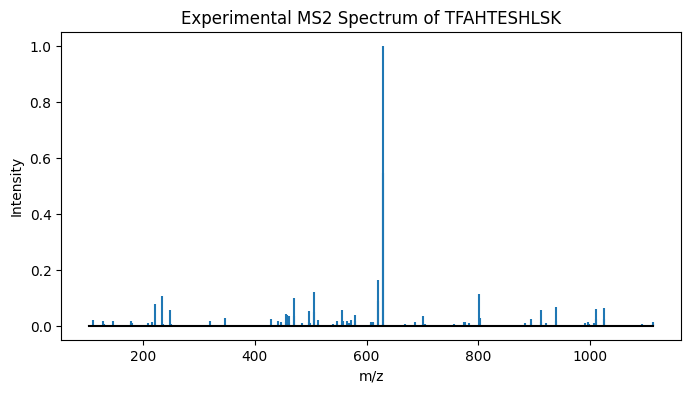

In [43]:
row = train_df.iloc[0]

plt.figure(figsize=(8, 4))
plt.stem(
    row["mz_array"],
    row["intensity_array"] / np.max(row["intensity_array"]),
    markerfmt="",
    basefmt="black",
)
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title(f'Experimental MS2 Spectrum of {row["target"]}')
plt.show()

The large peak in the middle is actually the precursor peak and not super relevant to MS2

### Removing precursor peak

We can write some code to remove the precursor peak

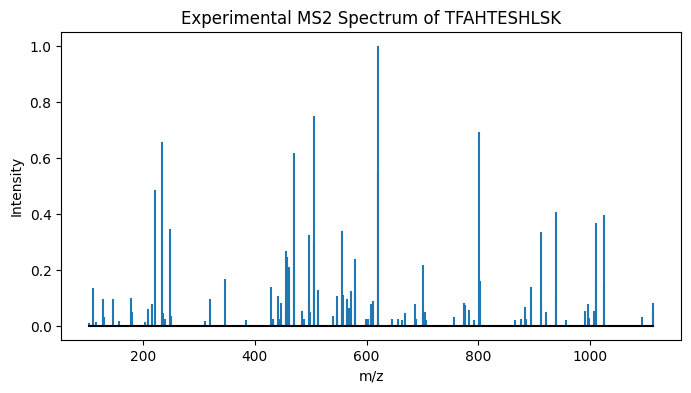

In [44]:
def remove_precursor(mz_array, intensity_array, precursor_mz, tol=2.0):
    # Calculate the absolute difference between mz_array and precursor_mz
    mz_array = np.array(mz_array)
    intensity_array = np.array(intensity_array)

    diff = np.abs(mz_array - precursor_mz)

    # Identify indices where the difference is within the tolerance
    indices_to_zero = diff <= tol

    # Zero out the intensity values at these indices
    intensity_array[indices_to_zero] = 0

    # Normalise here as well
    return intensity_array / intensity_array.max()


plt.figure(figsize=(8, 4))
plt.stem(
    row["mz_array"],
    remove_precursor(row["mz_array"], row["intensity_array"], row["precursor_mz"]),
    markerfmt="",
    basefmt="black",
)
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.title(f'Experimental MS2 Spectrum of {row["target"]}')
plt.show()

That looks much better!

Let's create a filtered column for the dataset

In [45]:
train_df["intensity_array_normalised"] = train_df.apply(
    lambda x: remove_precursor(x["mz_array"], x["intensity_array"], x["precursor_mz"]),
    axis=1,
)

### Comparison to a theoretical spectrum

All amino acids have a fixed mass. We can use this to calculate the theoretical spectrum of a given peptide! Let's do this for the predicted peptide.

First, we will define some helper functions to calculate the mass of a sequence.

After protein synthesis, some amino acids can undergo chemical alterations called [post-translational modification](https://en.wikipedia.org/wiki/Post-translational_modification) which change their masses, so we have to account for those. Also take note that the masses. Also note that the masses of the amino acids [Isoleucine](https://en.wikipedia.org/wiki/Isoleucine) and [Leucine](https://en.wikipedia.org/wiki/Leucine) are the same.

In [46]:
# Amino acid masses
residue_masses = {
    "G": 57.021464,
    "A": 71.037114,
    "S": 87.032028,
    "P": 97.052764,
    "V": 99.068414,
    "T": 101.047670,
    "C": 103.009185,
    "L": 113.084064,  # Beware!
    "I": 119.084064,  #Original 113.084064 # Mass of Isoleucine and Leucine are the same! #"L": 119.084064,  # Assuming a ^13C_6-label for leucine
    "N": 114.042927,
    "D": 115.026943,
    "Q": 128.058578,
    "K": 128.094963,
    "E": 129.042593,
    "M": 131.040485,
    "H": 137.058912,
    "F": 147.068414,
    "R": 156.101111,
    "Y": 163.063329,
    "W": 186.079313,
    # Post-translational modifications
    "M(+15.99)": 147.035400,  # Oxidation
    "C(+57.02)": 160.030649,  # Cysteine alkylation
    "N(+.98)": 115.026943,  # Deamidation
    "Q(+.98)": 129.042594,  # Deamidation
    "S(+79.97)": 166.998028,  # Phosphorylation
    "T(+79.97)": 181.01367,  # Phosphorylation
    "Y(+79.97)": 243.029329,  # Phosphorylation
}

tokenizer_regex = r"(\([^)]+\))|([A-Z](?:\([^)]+\))?)"

PROTON_MASS_AMU = 1.007276
H2O_MASS = 18.0106


def tokenize(sequence: str) -> list[str]:
    """Split a peptide represented as a string into a list of residues.

    Args:
        sequence (str): The peptide to be split.

    Returns:
        list[str]: The sequence of residues forming the peptide.
    """
    return [
        item
        for sublist in re.findall(tokenizer_regex, sequence)
        for item in sublist
        if item
    ]


def get_sequence_mass(sequence: list[str], charge: int | None) -> float:
    """Get the mass of a sequence.

    Args:
        sequence (list[str]):
            The residue sequence whose mass to calculate.
            All residues must be in residue_masses or
            this will raise a `KeyError`.
        charge (int | None, optional):
            Charge of the sequence to calculate the mass.

    Returns:
        float: The mass of the sequence in Daltons.
    """
    mass = sum([residue_masses[residue] for residue in sequence]) + H2O_MASS
    if charge:
        mass = (mass / charge) + PROTON_MASS_AMU
    return float(mass)

During mass spectrometry, peptides undergo collision induced dissociation (CID) within the mass spectormeter to break bonds typically along the peptide backbone. N-terminal fragments ions are classed b-ions; C-terminal fragment ions as y-ions. 

<figure>
<img src='https://www.ionsource.com/tutorial/DeNovo/art/aby_anno_frag.gif'/>
</figure>

<font color='grey'>Image source: [De Novo Peptide Sequencing Tutorial](https://www.ionsource.com/tutorial/DeNovo/nomenclature.htm)</font>


To find the theoretical spectra, we need to compute the masses of all combinations of the peptide

In [47]:
row = train_df.iloc[0]

sequence = row["preds_beam_0"]
print(f"          Sequence: {sequence}")
substrings = [sequence[: i + 1] for i in range(len(sequence))][:-1]
reverse_substrings = [sequence[i:] for i in range(len(sequence))][1:]
print("        Substrings: " + ", ".join(substrings))
print("Reverse substrings: " + ", ".join(reverse_substrings[::-1]))

          Sequence: TFAHTESHLSK
        Substrings: T, TF, TFA, TFAH, TFAHT, TFAHTE, TFAHTES, TFAHTESH, TFAHTESHL, TFAHTESHLS
Reverse substrings: K, SK, LSK, HLSK, SHLSK, ESHLSK, TESHLSK, HTESHLSK, AHTESHLSK, FAHTESHLSK


In [48]:
b_ions = [get_sequence_mass(x, charge=1) for x in substrings]
y_ions = [get_sequence_mass(x, charge=1) for x in reverse_substrings]

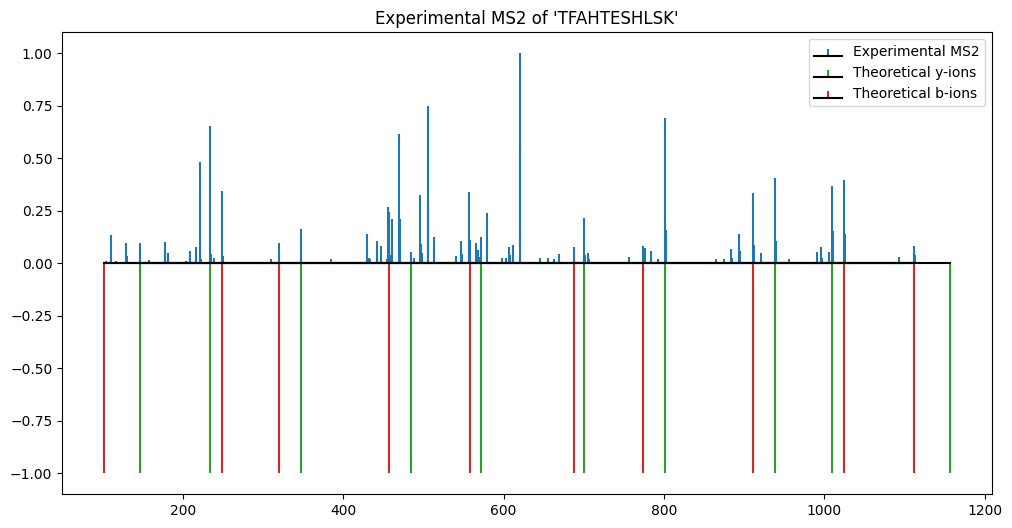

In [49]:
plt.figure(figsize=(12, 6))

plt.stem(
    row["mz_array"],
    row["intensity_array_normalised"],
    markerfmt="",
    basefmt="black",
)
plt.stem(
    np.array(y_ions),
    -np.ones(len(y_ions)),
    markerfmt="",
    linefmt="tab:green",
    basefmt="black",
)
plt.stem(
    np.array(b_ions) - H2O_MASS,
    -np.ones(len(b_ions)),
    markerfmt="",
    linefmt="tab:red",
    basefmt="black",
)
plt.legend(["Experimental MS2", "Theoretical y-ions", "Theoretical b-ions"])
plt.title(f"Experimental MS2 of '{row['target']}'")
plt.show()

As you can see, the peaks actually line up quite well with the theoretical spectra! The large experimental peak in the middle that doesn't have a corresponding theoretical peak is caused by the MS1 precursor and is generally removed before running InstaNovo.

**Hint: If we are able to compare the theoretical spectra to our experimental spectra, perhaps we could use this for filtering? If we predict the wrong peptide, it probably won't look similar to the experimental spectra! Could we do the same for Retention Time?**

Functions that might help:

In [50]:
def get_theoretical_spectrum(sequence):
    """Calculate theoretical y- and b- ions of a peptide."""
    if isinstance(sequence, str):
        sequence = tokenize(sequence)
    substrings = [sequence[: i + 1] for i in range(len(sequence))][:-1]
    reverse_substrings = [sequence[i:] for i in range(len(sequence))][1:]
    b_ions = [get_sequence_mass(x, charge=1) for x in substrings]
    y_ions = [get_sequence_mass(x, charge=1) for x in reverse_substrings]
    return np.concatenate([np.array(b_ions) - H2O_MASS, np.array(y_ions)])


def get_num_match(sequence, mz_array, tolerance=0.4):
    """Calculate the number of matching peaks."""
    experimental_spectrum = np.array(mz_array)
    theoretical_spectrum = np.array(get_theoretical_spectrum(sequence))
    differences = np.abs(experimental_spectrum[:, None] - theoretical_spectrum)

    # Count the number of experimental peaks that have at least one matching theoretical peak
    num_match = np.sum(np.any(differences < tolerance, axis=1))

    return num_match

### Improved theoretical spectrum with Prosit

We can improve our predicted spectrum with a tool like [Prosit](https://www.nature.com/articles/s41592-019-0426-7).

Prosit is a model trained to predict MS2 spectra given a peptide. We can call this model through [koinapy](https://pypi.org/project/koinapy/0.0.8/). See the example below!

In [51]:
def map_modification(peptide):
    mapping = {
        # Prosit uses a different notation for these modifications
        "M(+15.99)": "M[UNIMOD:35]",
        "C(+57.02)": "C[UNIMOD:4]",
        # Deamidation not supported by Prosit
        "N(+.98)": "N",
        "Q(+.98)": "Q",
        # Phosphorylation not supported by Prosit
        "S(+79.97)": "S",
        "T(+79.97)": "T",
        "Y(+79.97)": "Y",
    }
    return [mapping[residue] if residue in mapping else residue for residue in peptide]


# Initialize model
model = koinapy.Koina("Prosit_2020_intensity_HCD", "koina.wilhelmlab.org:443")


def compute_ion_identifications(
    dataset: pd.DataFrame, source_column: str, mz_tolerance: float
):
    matches = [
        find_matching_ions(
            source_mz=row[source_column],
            target_mz=row["mz_array"],
            target_intensities=row["intensity_array"],
            mz_tolerance=mz_tolerance,
        )
        for _, row in dataset.iterrows()
    ]
    return zip(*matches)


def find_matching_ions(
    source_mz: list[float],
    target_mz: list[float],
    target_intensities: list[float],
    mz_tolerance: float,
) -> tuple[list[float], list[float]]:
    try:
        num_matches, match_intensity = 0, 0.0
        for ion_mz in source_mz:
            nearest = bisect.bisect_left(target_mz, ion_mz)
            if nearest < len(target_mz):
                if target_mz[nearest] - ion_mz < mz_tolerance:
                    num_matches += 1
                    match_intensity += target_intensities[nearest]
                    continue
            if nearest > 0:
                if ion_mz - target_mz[nearest - 1] < mz_tolerance:
                    num_matches += 1
                    match_intensity += target_intensities[nearest - 1]
        return num_matches / len(source_mz), match_intensity / sum(target_intensities)
    except TypeError:
        print(source_mz)


def compute_prosit_features(mz_tolerance: float, dataset: pd.DataFrame) -> pd.DataFrame:
    inputs = pd.DataFrame()
    inputs["peptide_sequences"] = np.array(
        ["".join(peptide) for peptide in dataset["prediction"].apply(map_modification)]
    )
    inputs["precursor_charges"] = np.array(dataset["precursor_charge"])
    inputs["collision_energies"] = np.array(len(dataset) * [25])

    predictions: pd.DataFrame = model.predict(inputs, debug=True)
    predictions["Index"] = predictions.index

    grouped_predictions = predictions.groupby(by="Index").agg(
        {
            "peptide_sequences": "first",
            "precursor_charges": "first",
            "collision_energies": "first",
            "intensities": list,
            "mz": list,
            "annotation": list,
        }
    )
    grouped_predictions["intensities"] = grouped_predictions.apply(
        lambda row: np.array(row["intensities"])[np.argsort(row["mz"])].tolist(), axis=1
    )
    grouped_predictions["annotation"] = grouped_predictions.apply(
        lambda row: np.array(row["annotation"])[np.argsort(row["mz"])].tolist(), axis=1
    )
    grouped_predictions["mz"] = grouped_predictions["mz"].apply(np.sort)
    dataset["prosit_mz"] = grouped_predictions["mz"]
    dataset["prosit_intensity"] = grouped_predictions["intensities"]

    ion_matches, match_intensity = compute_ion_identifications(
        dataset=dataset, source_column="prosit_mz", mz_tolerance=mz_tolerance
    )
    dataset["ion_matches"] = ion_matches
    dataset["ion_match_intensity"] = match_intensity
    return dataset

InferenceServerException: The public koina network seems to be inaccessible at the moment. Please notify ludwig.lautenbacher@tum.de.

In [ ]:
idx = train_df["preds_beam_0"].map(lambda x: len(x) > 0)

subset_df = pd.DataFrame(
    {
        "ID": train_df.loc[idx, "ID"],
        "prediction": train_df.loc[idx, "preds_beam_0"].map(lambda x: tokenize(x)),
        "precursor_charge": train_df.loc[idx, "precursor_charge"],
        "mz_array": train_df.loc[idx, "mz_array"],
        "intensity_array": train_df.loc[idx, "intensity_array_normalised"],
    }
).reset_index(drop=True)

subset_df = compute_prosit_features(0.02, subset_df)

Prosit_2020_intensity_HCD::   0%|          | 0/99 [00:00<?, ?it/s]

The function above has added a few new columns to our `subset_df`:
- `prosit_mz` - predicted mz of prosit
- `prosit_intensity` - predicted intensity of prosit
- `ion_matches` - a score of ion matches
- `ion_match_intensity` - a score of how well the intensities match

In [ ]:
subset_df.head(3)

,ID,prediction,precursor_charge,mz_array,intensity_array,prosit_mz,prosit_intensity,ion_matches,ion_match_intensity
0,ID_2ohusw,"[T, F, A, H, T, E, S, H, L, S, K]",2,"[104.27165222, 110.06439209, 110.07133484, 116...","[0.010451220435291456, 0.011489022538836253, 0...","[147.11280822753906, 234.14483642578125, 249.1...","[0.13117513060569763, 0.4623885452747345, 0.35...",1.000,0.473327
1,ID_kkx9xc,"[T, F, A, H, T, E, S, H, L, S, K]",3,"[101.07060242, 102.05498505, 107.53672791, 109...","[0.11107643046397751, 0.06878625137960523, 0.0...","[147.11280822753906, 229.11334228515625, 234.1...","[0.08271019905805588, 0.007504046894609928, 0....",0.375,0.137436
2,ID_vbx3bu,"[Y, K, P, E, T, Q, H, E, L, A, V, H, K]",3,"[101.07051086, 101.10723114, 102.05454254, 110...","[0.015484900283428317, 0.004088850395434465, 0...","[147.11280822753906, 284.1717224121094, 292.16...","[0.01194774266332388, 0.020422758534550667, 0....",0.500,0.119059


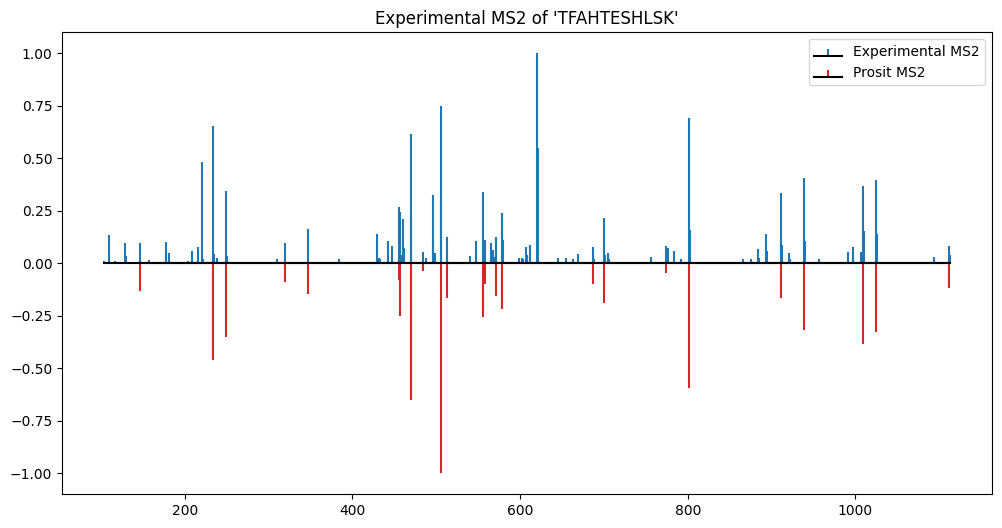

In [ ]:
prosit_row = subset_df.iloc[0]

plt.figure(figsize=(12, 6))

plt.stem(
    prosit_row["mz_array"],
    prosit_row["intensity_array"] / np.max(prosit_row["intensity_array"]),
    markerfmt="",
    basefmt="black",
)
plt.stem(
    prosit_row["prosit_mz"],
    -np.array(prosit_row["prosit_intensity"]),
    linefmt="tab:red",
    markerfmt="",
    basefmt="black",
)
plt.legend(["Experimental MS2", "Prosit MS2"])
plt.title(f"Experimental MS2 of '{''.join(prosit_row['prediction'])}'")
plt.show()

This looks much better than our simple approach from before! We still don't catch all the peaks, but some of these may also be noise.

## Calculating AUC and improving the curve

Below we have included some code to help calculate AUC and plot the precision recall curve

In [ ]:
def calculate_auc(targets, preds, log_probs, label=None, plot=True, xlim=0.7):
    conf = np.exp(log_probs)
    order = conf.argsort()[::-1]
    matches = np.array(targets == preds)
    matches = matches[order]
    conf = conf[order]

    csum = np.cumsum(matches)
    precision = csum / (np.arange(len(matches)) + 1)
    recall = csum / len(matches)

    # Calculate AUC
    width = recall[1:] - recall[:-1]
    height = np.minimum(precision[1:], precision[:-1])
    top = np.maximum(precision[1:], precision[:-1])
    side = top - height
    auc = (width * height).sum() + 0.5 * (side * width).sum()

    # Plot
    if plot:
        if label:
            plt.plot(recall, precision, label=f"{label} (AUC = {auc:.3f})")
        else:
            plt.plot(recall, precision, label=f"AUC = {auc:.3f}")
        plt.xlim(0, xlim)
        plt.ylim(0, 1)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)

    return auc

AUC: 0.644943



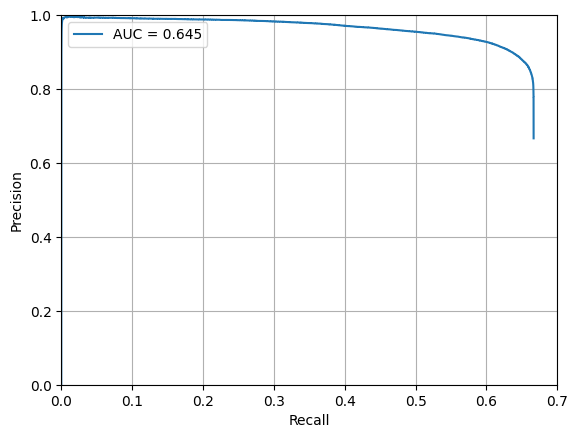

In [ ]:
auc = calculate_auc(
    train_df["target"], train_df["preds_beam_0"], train_df["log_probs_beam_0"]
)
print(f"AUC: {auc:.6f}\n")

The precision-recall curve looks pretty good for `train_df`!

_Note: `train_df` is actually a calibration set and our model has never seen these peptides!_

We can calculate the AUC plot the precision-recall curve for all five beams. As one might expect, the one with the highest log-probabilities (beam 0) does the best!

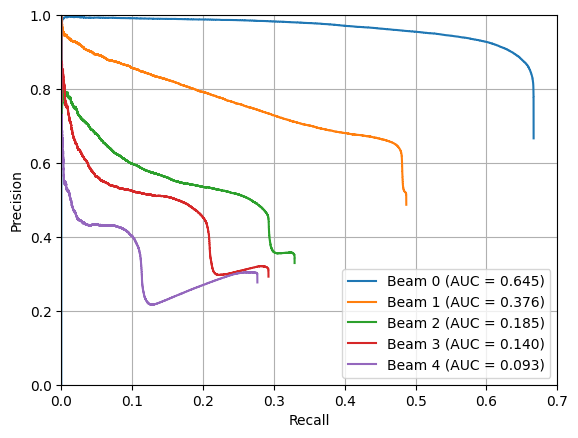

In [ ]:
for beam in range(5):
    auc = calculate_auc(
        train_df["target"],
        train_df[f"preds_beam_{beam}"],
        train_df[f"log_probs_beam_{beam}"],
        label=f"Beam {beam}",
    )

As one might expect, the performance gets significantly worse as we try the other beams but there may still be some useful information in them, especially the rank 2 beams (`beam_preds_1`). Perhaps there is some way to select the rank 2 beam if we know the rank 1 beam is incorrect?

**Hint: try comparing the theoretical mass of the predicted sequence to the precursor mass!**

## Filtering on precursor mass

Here is a function that can be used to check whether a sequence matches the precursor to some PPM tolerance

In [ ]:
# We have to consider isotopes! We will consider 0 to 1, but try using more!
max_isotope_error = 1
CARBON_MASS_DELTA = 1.00335


def _calc_mass_error(
    mz_theoretical: float, mz_measured: float, charge: int, isotope: int = 0
) -> float:
    """Calculate the mass error between theoretical and actual mz in ppm."""
    return float(
        (mz_theoretical - (mz_measured - isotope * CARBON_MASS_DELTA / charge))
        / mz_measured
        * 10**6
    )


def _mass(seq: str | list[str], charge: int | None = None) -> float:
    """Calculate a peptide's mass or m/z."""
    if isinstance(seq, str):
        seq = tokenize(seq)
    return get_sequence_mass(seq, charge)


def matches_precursor(
    seq: str | list[str],
    prec_mass: float,
    prec_charge: int,
    prec_tol: int = 50,
) -> tuple[bool, list[float]]:
    """Check if a sequence matches the precursor mass within some tolerance."""
    seq_mass = _mass(seq, charge=prec_charge)
    delta_mass_ppm = [
        _calc_mass_error(seq_mass, prec_mass, prec_charge, isotope)
        for isotope in range(0, max_isotope_error + 1)
    ]
    return any(abs(d) < prec_tol for d in delta_mass_ppm), delta_mass_ppm

We can use this to try and filter our predictions to a tighter tolerance of 20ppm!

In [ ]:
# Calculate whether it matches precursor for all beams
for i in range(5):
    train_df[f"delta_ppm_{i}"] = np.array(
        [
            # Find lowest ppm for all isotopes
            np.min(
                np.abs(
                    matches_precursor(
                        row[f"preds_beam_{i}"],
                        row["precursor_mz"],
                        row["precursor_charge"],
                        prec_tol=20,
                    )[1]
                )
            )
            if len(row[f"preds_beam_{i}"]) > 0
            else np.inf
            for _, row in train_df.iterrows()
        ]
    )

In [ ]:
ppm_tol = 20

preds = []
probs = []
for _, row in train_df.iterrows():
    pred = ""
    prob = -np.inf
    for i in range(5):
        if row[f"delta_ppm_{i}"] < ppm_tol:
            pred = row[f"preds_beam_{i}"]
            prob = row[f"log_probs_beam_{i}"]
            break
    preds.append(pred)
    probs.append(prob)

In [ ]:
train_df["preds_filtered"] = preds
train_df["probs_filtered"] = probs

Original AUC: 0.644943

Filtered AUC: 0.647149



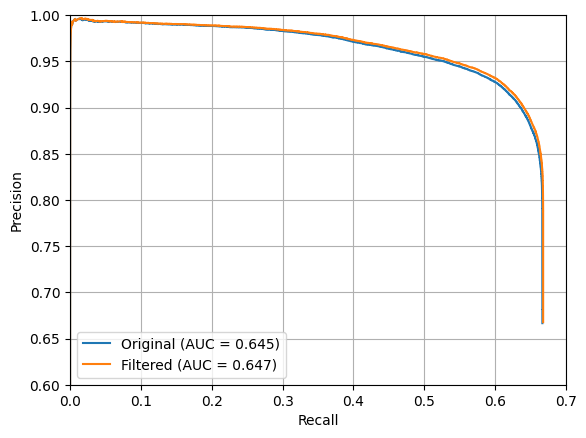

In [ ]:
auc = calculate_auc(
    train_df["target"],
    train_df["preds_beam_0"],
    train_df["log_probs_beam_0"],
    label="Original",
)
print(f"Original AUC: {auc:.6f}\n")
filtered_auc = calculate_auc(
    train_df["target"],
    train_df["preds_filtered"],
    train_df["probs_filtered"],
    label="Filtered",
)
print(f"Filtered AUC: {filtered_auc:.6f}\n")
plt.ylim([0.6, 1.0]);

Very small improvement but it works. This is just a proof-of-concept, you should try some other techniques!

### Using logistic regression

We will now do a simple logistic regression example to try and predict whether a sample is a false positive or not. 

First we will create a train and validation set

In [ ]:
# Add prosit features to training set
data_df = train_df.merge(
    subset_df[["ID", "ion_matches", "ion_match_intensity"]], on="ID", how="left"
).copy()
data_df["ion_matches"] = data_df["ion_matches"].fillna(0.0)
data_df["ion_match_intensity"] = data_df["ion_match_intensity"].fillna(0.0)
data_df["delta_ppm_0"] = data_df["delta_ppm_0"].replace(np.inf, 1000)
data_df["log_probs_beam_0"] = data_df["log_probs_beam_0"].replace(-np.inf, -100)
data_df.head(3)

,ID,exp_id,precursor_mz,precursor_mass,precursor_charge,retention_time,mz_array,intensity_array,preds_beam_0,log_probs_beam_0,...,intensity_array_normalised,delta_ppm_0,delta_ppm_1,delta_ppm_2,delta_ppm_3,delta_ppm_4,preds_filtered,probs_filtered,ion_matches,ion_match_intensity
0,ID_2ohusw,EXP_two56w,629.314941,1256.615331,2,11.883,"[104.27165222, 110.06439209, 110.07133484, 116...","[5718.949, 6286.8384, 74191.05, 6401.8403, 522...",TFAHTESHLSK,-0.024192,...,"[0.010451220435291456, 0.011489022538836253, 0...",0.288260,0.288260,26.138890,9.206688,26.138890,TFAHTESHLSK,-0.024192,1.000,0.473327
1,ID_kkx9xc,EXP_8pj4j3,419.878815,1256.614616,3,13.594,"[101.07060242, 102.05498505, 107.53672791, 109...","[23240.135, 14391.908, 4535.9688, 4619.1353, 5...",TFAHTESHLSK,-1.219249,...,"[0.11107643046397751, 0.06878625137960523, 0.0...",0.279373,0.279373,2.969038,19839.693595,19839.693595,TFAHTESHLSK,-1.219249,0.375,0.137436
2,ID_vbx3bu,EXP_xrjdxh,527.278381,1578.813316,3,16.418,"[101.07051086, 101.10723114, 102.05454254, 110...","[15584.973, 4115.275, 12363.395, 327275.22, 16...",YKPETQHELAVHK,-0.553875,...,"[0.015484900283428317, 0.004088850395434465, 0...",1.361050,1.361050,1.361050,1.361050,1.361050,YKPETQHELAVHK,-0.553875,0.500,0.119059


In [ ]:
type(subset_df)

pandas.core.frame.DataFrame

In [ ]:
subset_df.shape

(98059, 9)

In [ ]:
subset_df[:10000]

,ID,prediction,precursor_charge,mz_array,intensity_array,prosit_mz,prosit_intensity,ion_matches,ion_match_intensity
0,ID_2ohusw,"[T, F, A, H, T, E, S, H, L, S, K]",2,"[104.27165222, 110.06439209, 110.07133484, 116...","[0.010451220435291456, 0.011489022538836253, 0...","[147.11280822753906, 234.14483642578125, 249.1...","[0.13117513060569763, 0.4623885452747345, 0.35...",1.000000,0.473327
1,ID_kkx9xc,"[T, F, A, H, T, E, S, H, L, S, K]",3,"[101.07060242, 102.05498505, 107.53672791, 109...","[0.11107643046397751, 0.06878625137960523, 0.0...","[147.11280822753906, 229.11334228515625, 234.1...","[0.08271019905805588, 0.007504046894609928, 0....",0.375000,0.137436
2,ID_vbx3bu,"[Y, K, P, E, T, Q, H, E, L, A, V, H, K]",3,"[101.07051086, 101.10723114, 102.05454254, 110...","[0.015484900283428317, 0.004088850395434465, 0...","[147.11280822753906, 284.1717224121094, 292.16...","[0.01194774266332388, 0.020422758534550667, 0....",0.500000,0.119059
3,ID_6lvy01,"[Q, S, L, L, N, S, Q, P, L, P, K, Q, E, V, L, ...",3,"[100.1067276, 100.16323853, 101.07076263, 101....","[0.00470601855430533, 0.003048750700949843, 0....","[88.06311798095703, 175.11895751953125, 213.10...","[0.003775946097448468, 0.04684437811374664, 0....",0.166667,0.010314
4,ID_pocgui,"[E, L, F, D, L, E, E, L, S, S, F, P, S, L, N, ...",2,"[100.88684845, 110.16357422, 110.28112793, 116...","[0.01005418397531554, 0.00847406503421399, 0.0...","[147.11280822753906, 243.13392639160156, 260.1...","[0.04801434651017189, 0.19759225845336914, 0.0...",0.785714,0.276585
...,...,...,...,...,...,...,...,...,...
9995,ID_b777ic,"[F, F, L, T, G, T, S, L, F, V, K]",2,"[107.2833252, 107.29208374, 107.39506531, 107....","[0.021560261506510792, 0.004647440634358211, 0...","[147.11280822753906, 246.18121337890625, 255.1...","[0.0453006885945797, 0.03177634999155998, 0.00...",0.652174,0.459065
9996,ID_3s4pxo,"[G, M(+15.99), C, V, P, V, L, K, D, L, L, H, L...",4,"[106.36103821, 109.86320496, 110.07083893, 113...","[0.009091962423333967, 0.012660791338097952, 0...","[147.11280822753906, 205.0641326904297, 215.12...","[0.029293200001120567, 0.24733614921569824, 0....",0.520833,0.242741
9997,ID_v5k2xs,"[N, L, L, S, L, N, M(+15.99), D, L, E, R]",2,"[103.27220917, 103.28076172, 103.38368988, 103...","[0.4546710443428811, 0.1529290934786077, 0.173...","[175.11895751953125, 214.62881469726562, 228.1...","[0.054830677807331085, 0.0029116347432136536, ...",0.625000,0.054290
9998,ID_ea3ldo,"[F, G, T, G, T, Y, A, G, G, E, K]",2,"[101.07109833, 101.10781097, 102.05514526, 102...","[0.0038993465917715542, 0.0022298928221778634,...","[147.11280822753906, 182.0867919921875, 205.09...","[0.08738373965024948, 0.006306588649749756, 0....",0.727273,0.249301


In [ ]:
# y-data profiling experiment
# from ydata_profiling import ProfileReport

# ProfileReport(subset_df[:10000], title="Snakes and Venom")

In [1]:
# change the validation split based on 3 sets: stratified KFold or Kfold
train, valid = train_test_split(data_df, random_state=42, test_size=0.4)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
train.shape, valid.shape

NameError: name 'train_test_split' is not defined

In [31]:

train_labels = train["target"] == train["preds_beam_0"]
valid_labels = valid["target"] == valid["preds_beam_0"]

In [32]:
features = [
    "precursor_mz",
    "precursor_charge",
    "delta_ppm_0",
    "ion_matches",
    "ion_match_intensity",
]

X_train = train[features]
X_valid = valid[features]

# Change the C and class_weight based on the dataset
# preferably use mlflow to track features
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, train_labels)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [41]:
# run predictions: preds and probs
preds = clf.predict(X_valid)
probs = clf.predict_proba(X_valid)

# print the accuracy score
print(accuracy_score(valid_labels, preds))

# print balanced accuracy score
import sklearn.metrics as metrics
balanced_accuracy = metrics.balanced_accuracy_score(valid_labels, preds)
balanced_accuracy

0.7917


0.7765041690201746

Plot the confusion matrix:

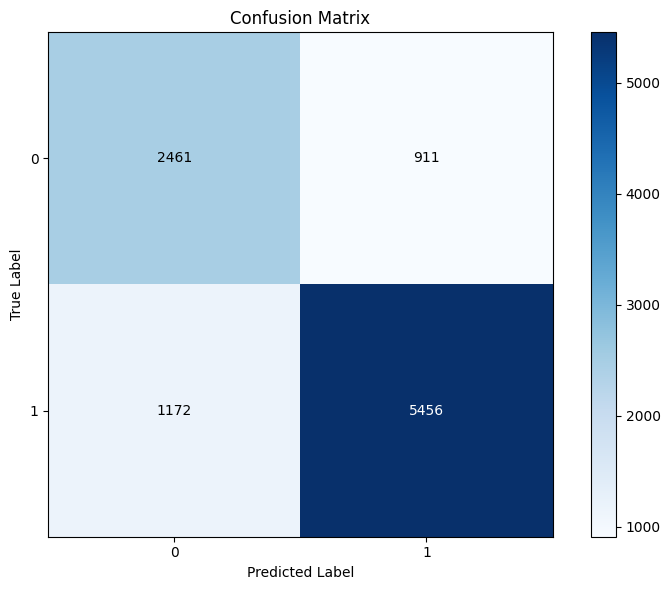

In [34]:
conf_matrix = confusion_matrix(valid_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(len(set(valid_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Adding the numbers in the cells
thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j,
            i,
            format(conf_matrix[i, j], "d"),
            ha="center",
            va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.show()

In [35]:
print(classification_report(valid_labels, preds))

              precision    recall  f1-score   support

       False       0.68      0.73      0.70      3372
        True       0.86      0.82      0.84      6628

    accuracy                           0.79     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.80      0.79      0.79     10000



So we can predict with reasonable accuracy when prediction is incorrect, how does these affect AUC?

In [36]:
filtered_preds = valid["preds_filtered"].copy()
filtered_probs = valid["probs_filtered"].copy()

idx = (preds == 0) & (probs[:, 0] > 0.85)
filtered_preds.loc[idx] = ""
filtered_probs.loc[idx] = -np.inf

Original AUC: 0.640230

Filtered AUC: 0.640995



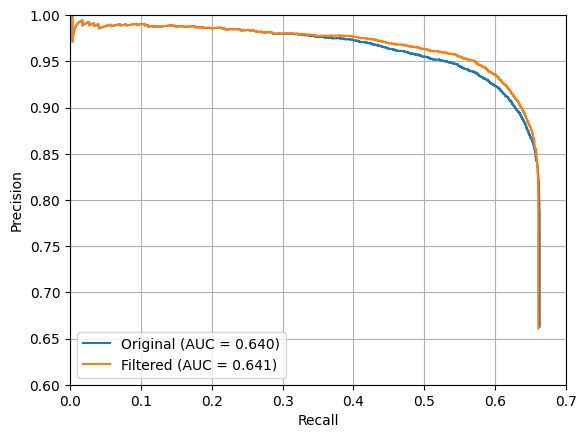

In [37]:
auc = calculate_auc(
    valid["target"], valid["preds_beam_0"], valid["log_probs_beam_0"], label="Original"
)
print(f"Original AUC: {auc:.6f}\n")
filtered_auc = calculate_auc(
    valid["target"], filtered_preds, filtered_probs, label="Filtered"
)
print(f"Filtered AUC: {filtered_auc:.6f}\n")
plt.ylim([0.6, 1.0]);

It works, but can definitely be improved!

## Creating a submission file

Since we now know beam 0 is the best, let's try create a submission file to get a baseline AUC score on the test set!

In [38]:
test_df.head(3)

,ID,exp_id,precursor_mz,precursor_mass,precursor_charge,retention_time,mz_array,intensity_array,preds_beam_0,log_probs_beam_0,preds_beam_1,log_probs_beam_1,preds_beam_2,log_probs_beam_2,preds_beam_3,log_probs_beam_3,preds_beam_4,log_probs_beam_4
0,ID_6ij0wu,EXP_yu8x32,587.81171,1174.61614,2,41.8792,"[104.27165222, 110.06439209, 110.07133484, 116...","[5718.949, 6286.8384, 74191.05, 6401.8403, 522...",VSEELEDLLK,-0.322313,VSEELEDLLK,-1.929051,VSEELEDLLK,-2.653483,VSEELEDLLK,-3.966449,VSQ(+.98)ELEDLLK,-4.217722
1,ID_lzos7i,EXP_yu8x32,629.63892,1886.90219,3,20.8736,"[101.07060242, 102.05498505, 107.53672791, 109...","[23240.135, 14391.908, 4535.9688, 4619.1353, 5...",NPEETPRPLS(+79.97)PVQNTK,-23.293793,LPEETPRPLS(+79.97)PVQNTK,-23.770130,LPEETPRPLS(+79.97)PVQNTK,-24.996239,APEETPRPLS(+79.97)PVQNTK,-28.089029,APEETPRPLS(+79.97)PVQNTK,-28.089029
2,ID_2jrjcu,EXP_yu8x32,638.29059,1275.57390,2,23.5429,"[101.07051086, 101.10723114, 102.05454254, 110...","[15584.973, 4115.275, 12363.395, 327275.22, 16...",THLMSESEWR,-0.075819,THLMSETDWR,-2.886961,THLMSESEWR,-5.700818,THLMSETDWR,-6.222891,SHLMSETEWR,-18.293968


In our submission file, we expect you to submit the predicted peptide along with the model confidence.

_NOTE: Model confidence is not log probabilities! Use `np.exp()`!_

In [39]:
sub_df = test_df[["ID"]].copy()
sub_df["target"] = test_df["preds_beam_0"]
sub_df["confidence"] = np.exp(test_df["log_probs_beam_0"])
sub_df.head()

,ID,target,confidence
0,ID_6ij0wu,VSEELEDLLK,7.244711e-01
1,ID_lzos7i,NPEETPRPLS(+79.97)PVQNTK,7.649523e-11
2,ID_2jrjcu,THLMSESEWR,9.269841e-01
3,ID_n3p24j,VNLFLLGK,4.440058e-01
4,ID_5xq54g,S(+79.97)GVLLVQAHSHVR,3.110454e-07


Save to a csv file for uploading to Zindi:

In [40]:
sub_df.to_csv("submissions/SampleSumbission_adjust_leucine_balanced_classes.csv", index=False)